In [1]:
import torch
import os
import sys
import numpy as np
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import DataLoader
if "/opt/ml/level2_cv_semanticsegmentation-cv-09" not in sys.path:
    sys.path.append(os.path.join("/opt/ml/level2_cv_semanticsegmentation-cv-09"))
from utils import seed_everything
from dataset.dataset import XRayDataset, split_dataset
from dataset.transforms import get_train_transform
from tqdm import tqdm
from optim.losses import dice_coef

### Path 설정

In [2]:
model_path = "/opt/ml/level2_cv_semanticsegmentation-cv-09/checkpoint/unet_1024_combine_cutmix_best.pt"
image_path = "/opt/ml/train/DCM/ID001/image1661130828152_R.png"

img_size = (1024,1024)
seed_everything(42)
BATCH_SIZE = 6

### sample data 추출

In [3]:
model = torch.load(model_path, map_location='cpu')
model.eval()

val_transform = get_train_transform(train=False,img_size=img_size)
    
train_filenames, train_labelnames, val_filenames, val_labelnames = split_dataset()
val_dataset = XRayDataset(
                        filenames = val_filenames,
                        labelnames = val_labelnames,
                        is_train = False,
                        transforms= val_transform
                        )

In [4]:
img, label = val_dataset.__getitem__(0)
img = img.unsqueeze(0)
label = label.unsqueeze(0)
print(img.shape, label.shape)

torch.Size([1, 3, 1024, 1024]) torch.Size([1, 29, 2048, 2048])


In [5]:
img = img.to('cuda')
model = model.to('cuda')

logit = model(img)
output = F.interpolate(logit,size=(2048,2048),mode="bilinear")
sig_output = torch.sigmoid(output).cpu()
print(sig_output.shape)

torch.Size([1, 29, 2048, 2048])


### sample data에 대한 클래스별 확률 분포 추출

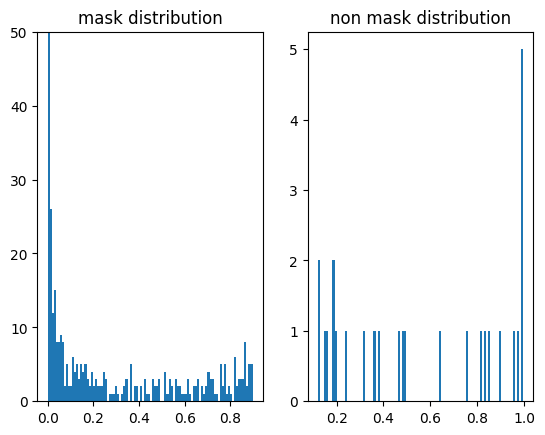

In [6]:
import matplotlib.pyplot as plt

for i, (predict,mask) in enumerate(zip(sig_output[0],label[0])):
    if i==26:
        mix = predict*mask
        distri = mix[(0.9>mix) & (mix>0)].cpu().data.numpy()
        zero_mask = mask==0
        other = predict*zero_mask
        other = other[other>0.1].cpu().data.numpy()
        
        plt.subplot(1,2,1)
        plt.title('mask distribution')
        plt.hist(distri, bins=100)
        plt.ylim(0,50)
        
        plt.subplot(1,2,2)
        plt.title('non mask distribution')
        plt.hist(other, bins=100)


In [7]:
val_loader = DataLoader(
        dataset=val_dataset, 
        batch_size=BATCH_SIZE,
        shuffle=False,
        drop_last=False
    )
mask_hist = np.zeros((29, 100))
other_hist = np.zeros((29, 100))

with torch.no_grad():
    model = model.cuda()
    n_class = len(XRayDataset.CLASSES)
    cnt = 0
    dices = []
    with tqdm(total=len(val_loader)) as pbar:
        for images, masks in val_loader:
            images = images.cuda()        
            
            outputs = model(images)
            
            output_h, output_w = outputs.size(-2), outputs.size(-1)
            mask_h, mask_w = masks.size(-2), masks.size(-1)
            
            # restore original size
            if output_h != mask_h or output_w != mask_w:
                outputs = F.interpolate(outputs, size=(mask_h, mask_w), mode="bilinear")
            
            sig_output = torch.sigmoid(outputs)
            for i in range(29):
                if i==26 or i == 20:
                    sig_output[:,i] = (sig_output[:,i]> 0.9)
                else:
                    sig_output[:,i] = (sig_output[:,i]> 0.3)
            sig_output = sig_output.detach().cpu()
            
            dice = dice_coef(sig_output, masks)
            dices.append(dice)
            for b in range(sig_output.size(0)):
                for i, (predict,mask) in enumerate(zip(sig_output[b],masks[b])):
                    mix = predict*mask
                    distri = mix[(mix>0)].data.numpy()
                    
                    zero_mask = mask==0
                    other = predict*zero_mask
                    other = other[other > 0].data.numpy()
            
                    out_mask, _ = np.histogram(distri,bins=100, range=(0,1))
                    out_other,_ = np.histogram(other,bins=100, range=(0,1))
                    
                    mask_hist[i] += out_mask
                    other_hist[i] += out_other
                    
            pbar.update(1)
    dices = torch.cat(dices, dim=0)
    dices_per_class = torch.mean(dices, dim=0)
    dice_str = [
        f"{c:<12}: {d.item():.4f}"
        for c, d in zip(XRayDataset.CLASSES, dices_per_class)
    ]
    dice_str = "\n".join(dice_str)
    avg_dice = torch.mean(dices_per_class).item()


100%|██████████| 27/27 [04:23<00:00,  9.77s/it]


In [8]:
print(dice_str)
print(avg_dice)

finger-1    : 0.9630
finger-2    : 0.9823
finger-3    : 0.9799
finger-4    : 0.9742
finger-5    : 0.9767
finger-6    : 0.9861
finger-7    : 0.9847
finger-8    : 0.9766
finger-9    : 0.9800
finger-10   : 0.9873
finger-11   : 0.9792
finger-12   : 0.9755
finger-13   : 0.9783
finger-14   : 0.9858
finger-15   : 0.9804
finger-16   : 0.9706
finger-17   : 0.9710
finger-18   : 0.9836
finger-19   : 0.9842
Trapezium   : 0.9493
Trapezoid   : 0.9217
Capitate    : 0.9635
Hamate      : 0.9517
Scaphoid    : 0.9651
Lunate      : 0.9568
Triquetrum  : 0.9561
Pisiform    : 0.9292
Radius      : 0.9834
Ulna        : 0.9822
0.9709770679473877


(29, 100)
(29, 100)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


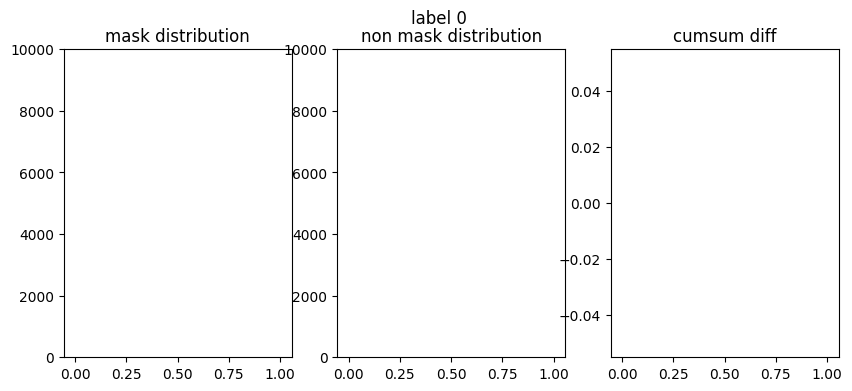

In [9]:
print(mask_hist.shape)
print(other_hist.shape)
bins = np.linspace(0,1,100)

def reverse_cumulative(hist):
    return np.cumsum(hist[::-1])[::-1]

def normalize(array):
    min_val = array.min()
    max_val = array.max()
    nor = (array-min_val) / (max_val - min_val)
    nor = nor*2 -1
    return nor

for i in range(29):
    plt.figure(figsize=(10,4))
    plt.suptitle(f"label {i}")
    # mask에 해당하는 이미지의 확률분포
    plt.subplot(1,3,1)
    plt.title('mask distribution')
    plt.bar(bins,mask_hist[i], width = 1/100)
    plt.ylim(0,10000)
    
    # mask가 아닌 이미지의 확률분포
    plt.subplot(1,3,2)
    plt.title('non mask distribution')
    plt.bar(bins, other_hist[i], width = 1/100)
    plt.ylim(0,10000)
    
    # 두개의 누적합의 차이
    cumulative_hist = mask_hist[i]-other_hist[i]
    cumulative_hist = reverse_cumulative(cumulative_hist)
    # cumulative_hist = reverse_cumulative(mask_hist[i])-reverse_cumulative(other_hist[i])
    # cumulative_hist = normalize(cumulative_hist)
    plt.subplot(1,3,3)
    plt.title('cumsum diff')
    plt.bar(bins, cumulative_hist, width = 1/100)
    plt.title(f"max threshold {np.argmax(cumulative_hist)*0.01}")
    
    plt.show()